<center>
<h1>Mining the Bible verses</h1>
<h2>A practitioner's exploration into what’s possible using text mining on religious corpora.</h2>
<h3>Arian Pasquali</h3>
<h4>heavily based on J. Monteiro's work (https://github.com/jmmonteiro) </h4>
<h3>Porto, Novembro 2018</h3>
</center>

The bible verses corpora is a well structure dataset that offers interesting opportunities to test different NLP methods. This notebook is an attempt to explore some fun topics. I hope to apply the same techniques using other religious corpora in the future.

## Load dependecies


In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install gensim
!pip install nltk

## Load packages
The first step is to load some of the packages necessary to run the analysis. The last line specifies the size of the plots that will be displayed.

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15,10)

## Load data

Let's start by loading the data and checking how many samples we have.

In [2]:
bible = pd.read_csv('./corpus/bible_data_set.csv')
bible.shape

(31102, 5)

Next, we'll encode some extra information about the verses, namely, which testament and book they belong to. A quick google search tells us which books are contained in the KJV.

In [3]:
# Books in the Old Testament (OT) and New Testament (NT)
OT_books = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges',
            'Ruth', '1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles',
            'Ezra', 'Nehemiah', 'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
            'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel', 'Daniel',
            'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah', 'Nahum', 'Habakkuk',
            'Zephaniah', 'Haggai',    'Zechariah',    'Malachi']

NT_books = ['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians',
            '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians',
            '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
            'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
            'Revelation']

# New variables with the books and testaments as categories
books = pd.unique(bible.book)
book_codes = np.arange(1,len(books)+1)
book_codes = np.concatenate([books.reshape((-1,1)),book_codes.reshape((-1,1))], axis=1)

bible['book_code'] = np.nan
bible['testament'] = ''
bible['testament_code'] = np.nan
for i in range(0,bible.shape[0]):
    ind = bible.at[i,'book'] == book_codes[:,0]
    bible.at[i,'book_code'] = book_codes[ind,1]
    
    if bible.at[i,'book'] in OT_books:
        bible.at[i,'testament'] = 'Old Testament'
        bible.at[i,'testament_code'] = 0
    elif bible.at[i,'book'] in NT_books:
        bible.at[i,'testament'] = 'New Testament'
        bible.at[i,'testament_code'] = 1
    else:
        raise Exception('Book not found: ' + bible.at[i,'book'])

bible.book_code = bible.book_code.astype(int)
bible.book_code = pd.Categorical(bible.book_code)
bible.testament_code = bible.testament_code.astype(int)
bible.testament_code = pd.Categorical(bible.testament_code)
    
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,1,Old Testament,0
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",1,Old Testament,0
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",1,Old Testament,0
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",1,Old Testament,0
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",1,Old Testament,0


Before starting the analysis, I'll permute the data. This will break the order of the verses, preventing cases in which a structured chunk of the data (e.g. a chapter) is contained completely on the train set or on the test set. In other words, we want to have the chapters spread around the cross-validation folds.

In order to avoid problems with the cross-validation later on, I'll reset the index as well.

In [4]:
bible = bible.sample(frac=1, random_state=7).reset_index(drop=True)
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Psalms 12:2,Psalms,12,2,They speak vanity every one with his neighbour...,19,Old Testament,0
1,Ruth 2:7,Ruth,2,7,"And she said, I pray you, let me glean and gat...",8,Old Testament,0
2,Ezekiel 33:10,Ezekiel,33,10,"Therefore, O thou son of man, speak unto the h...",26,Old Testament,0
3,Psalms 139:1,Psalms,139,1,"O lord, thou hast searched me, and known me. \n",19,Old Testament,0
4,Judges 9:34,Judges,9,34,"And Abimelech rose up, and all the people that...",7,Old Testament,0


Looking good so far. Time for some machine learning.

## Book classification

### Defining SVM model setup and weighted vector space model


Since it was easy to classify the verses based on the testament, let's go one step further and see if we can predict the book from which they came from.

The procedure is very similar, but now the categories in the labels $\boldsymbol{y}$ are different, and the code to compute the class accuracies is more complex. We'll also introduce a new visualisation tool: the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [32]:
bible["book"].unique()

array(['Psalms', 'Ruth', 'Ezekiel', 'Judges', 'Numbers', '1 Kings',
       'Isaiah', 'Acts', 'Matthew', 'Song of Solomon', 'Mark', 'Malachi',
       'Exodus', 'Jeremiah', 'Joshua', 'Luke', '2 Samuel', 'Deuteronomy',
       'Job', 'Galatians', 'Genesis', 'Joel', '1 Corinthians', 'Titus',
       'John', '2 Chronicles', '2 Timothy', 'Proverbs', 'Zechariah',
       '1 Chronicles', 'Hebrews', '1 Samuel', 'Hosea', '2 Kings', 'Ezra',
       'Revelation', 'Nehemiah', 'Leviticus', 'Ecclesiastes', 'Amos',
       'Ephesians', 'Lamentations', '1 Thessalonians', 'James', 'Esther',
       'Habakkuk', 'Romans', 'Daniel', 'Philippians', '2 Corinthians',
       '1 Timothy', 'Nahum', '2 John', 'Jonah', '1 Peter', 'Obadiah',
       'Micah', '1 John', 'Haggai', 'Zephaniah', '2 Peter', 'Colossians',
       'Philemon', '2 Thessalonians', 'Jude', '3 John'], dtype=object)

In [91]:
interesting_books = ['Genesis',
                    'Exodus',
                    'Proverbs',
                    'Revelation',
                    'Matthew', 
                    'Mark',
                    'John',
                    'James',
                    'Daniel',
                    'Jude',]

#filter only books I'm interested in
interesting_bible = bible[bible['book'].isin(interesting_books)]
interesting_bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
10,Matthew 13:30,Matthew,13,30,Let both grow together until the harvest: and ...,40,New Testament,1
12,Mark 10:7,Mark,10,7,For this cause shall a man leave his father an...,41,New Testament,1
14,Exodus 34:16,Exodus,34,16,And thou take of their daughters unto thy sons...,2,Old Testament,0
28,Genesis 24:18,Genesis,24,18,"And she said, Drink, my lord: and she hasted, ...",1,Old Testament,0
36,Matthew 26:14,Matthew,26,14,"Then one of the twelve, called Judas Iscariot,...",40,New Testament,1


In [92]:
from sklearn.metrics import accuracy_score



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# using count vectorized
vect = CountVectorizer(ngram_range=(1,3),
                        token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_-]+(?:\\b|(?=[_-]))')

# using TF.IDF
#vect = TfidfVectorizer(
#    sublinear_tf=True,
#    ngram_range=(1,3),
#    token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_-]+(?:\\b|(?=[_-]))'
#)

In [93]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

machine = LinearSVC(class_weight='balanced', loss='squared_hinge')
clf = OneVsRestClassifier(machine)

X = interesting_bible.text
y = np.asarray(interesting_bible.book)

acc = []
class_acc = []
conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))

In [94]:
X.head()

10    Let both grow together until the harvest: and ...
12    For this cause shall a man leave his father an...
14    And thou take of their daughters unto thy sons...
28    And she said, Drink, my lord: and she hasted, ...
36    Then one of the twelve, called Judas Iscariot,...
Name: text, dtype: object

In [103]:
import warnings; warnings.simplefilter('ignore')

In [105]:
n_cv_folds = 10

# Use the stratified KFold strategy, in order to preserve the proportion of each class in all the folds
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=n_cv_folds)

acc = []
class_acc = []

#folds = []
for train_index, test_index in cv.split(np.zeros(len(y)), y):
    print("training fold...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    # General accuracy
    acc.append(accuracy_score(y_test,y_pred))
    
    # Class accuracy
    fold_class_acc = []
    for c in np.unique(y):
        ind = y_test == c
        dummy = np.sum(y_test[ind] == y_pred[ind])
        fold_class_acc.append(dummy/np.sum(ind))
    class_acc.append(fold_class_acc)    
    
    # Accuracy
    acc.append(accuracy_score(y_test,y_pred))
    
    # Confusion matrix
    conf_mat = conf_mat + confusion_matrix(y_test,y_pred)

training fold...
training fold...
training fold...
training fold...
training fold...
training fold...
training fold...
training fold...
training fold...
training fold...


Let's check the accuracies.

In [96]:
print('Accuracy: ' + str(np.mean(acc)))
print('Balanced Accuracy: ' + str(np.mean(class_acc[:])))

Accuracy: 0.7555277102231217
Balanced Accuracy: 0.6285094861811176


They're around 0.7 (70%), but don't forget that this is no binary classification task. This sample has about 10 selected books, so if the model was predicting the labels randomly, the accuracy would be around 1/10 (assuming equally sized classes), which is approximately 0.10 (10%).

Before taking a look at the confusion matrix. We should bear in mind that each book has a very different number of verses. In order to visualise the results better, a normalised version of the confusion matrix is created below, where the entries in each row (true labels) are divided by the number of samples in the corresponding class (i.e. row).

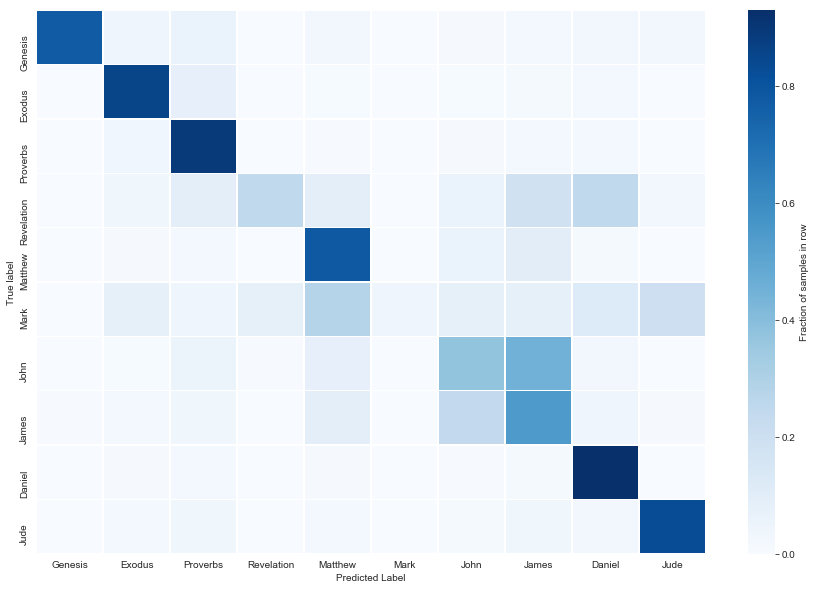

<Figure size 1080x720 with 0 Axes>

In [97]:
conf_mat_norm = np.transpose(np.transpose(conf_mat)/np.sum(conf_mat,axis=1))

ax = sns.heatmap(conf_mat_norm,cmap="Blues",
            xticklabels=interesting_books, yticklabels=interesting_books,
            linewidths=.5, cbar_kws={'label': 'Fraction of samples in row'})
ax.set(xlabel = 'Predicted Label', ylabel='True label')

plt.figure(figsize=(15,10))
plt.show()

As we can see, the accuracy of each class differs quite a bit, which means that some verses are easier to classify than others. Since we are using a bag-of-words model, this suggests that the classes with a higher accuracy contain verses with words which are quite different from the ones in the rest of the Bible. For example, the Genesis is easier to classify than the books at the end of the OT.

There seems to be a slightly higher similarity between books in the NT, specially between the first NT books, e.g. from Matthew to Corinthians. In fact, we can faintly see the "border" between the OT and the NT (between Malachi and Matthew). We can also sort the books by their class accuracies, which will give us an idea which books are more "unique", i.e. easier to classify.

In [107]:
#all books
books

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi',
       'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans',
       '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians',
       'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians',
       '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James',
       '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
       'Revelation'], dtype=object)

In [99]:
np.array(interesting_books)

array(['Genesis', 'Exodus', 'Proverbs', 'Revelation', 'Matthew', 'Mark',
       'John', 'James', 'Daniel', 'Jude'], dtype='<U10')

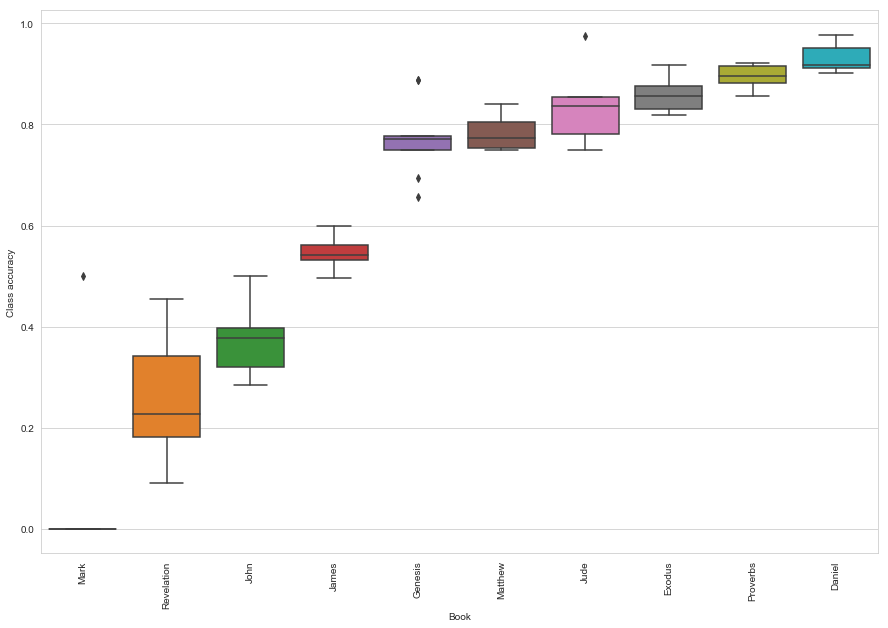

<Figure size 1080x720 with 0 Axes>

In [100]:
class_acc_plot = np.array(class_acc)
m = np.mean(class_acc,axis=0)

i = np.argsort(m)
class_acc_plot = class_acc_plot[:,i]
books_plot = np.array(interesting_books)[i]

class_acc_plot = pd.DataFrame(class_acc_plot, columns=books_plot)

ax = sns.boxplot(data=class_acc_plot)
ax.set(xlabel = 'Book', ylabel='Class accuracy')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.figure(figsize=(15,10))
plt.show()

# Conclusion

And that's it!

We could probably get a higher accuracy by using more [n-grams](https://en.wikipedia.org/wiki/Bag-of-words_model#N-gram_model) instead of just individual words (i.e. unigrams). However, this would also increase the number of features in the dataset. Alternatively, we could use more complex models, which take into account the context of the words. If I get around to implement them, I might revisit this problem.

**note**

This work is inpired in the work of https://github.com/jmmonteiro. 